# Estabilidade

Neste notebook vamos estudar técnicas que tornam o treinamento de redes neurais mais **estável** e eficiente.  
O objetivo é entender como escolhas de **normalização, inicialização de parâmetros, dropout e ajuste dinâmico da taxa de aprendizado** afetam a convergência e o desempenho do modelo.

Pontos que abordaremos:

- **Normalização de entradas e ativações internas**  
- **Batch Normalization**  
- **Inicialização de parâmetros (Xavier, He, etc.)**  
- **Schedulers de Learning Rate**  

Esses elementos ajudam a evitar problemas clássicos como **gradientes explosivos/vanishing**, **treinamento instável** e **convergência lenta**.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Normalização

A normalização é uma técnica fundamental em redes neurais para acelerar e estabilizar o treinamento. A ideia é controlar a escala e a distribuição dos dados, seja na entrada da rede ou entre camadas, reduzindo problemas de gradientes desbalanceados e acelerando a convergência.

### Input Normalization

Antes do treinamento, normalizamos os dados de entrada $x$ para que apresentem **média próxima de zero** e **desvio padrão próximo de um**:

$$
x' = \frac{x - \mu}{\sigma}
$$

- $\mu$: média global do dataset  
- $\sigma$: desvio padrão global  

Isso garante que todas as features estejam em escalas comparáveis.  
Vamos calcular $\mu$ e $\sigma$ para o dataset **MNIST**, que contém imagens em tons de cinza de dígitos manuscritos, e em seguida podemos aplicar a normalização diretamente durante o carregamento dos dados usando `transforms.Normalize`.

In [3]:
import torchvision
import torchvision.transforms as transforms

# Carregar dataset apenas como Tensor
dataset_tmp = torchvision.datasets.MNIST(
    root="./data", train=True, download=True,
    transform=transforms.ToTensor()
)

# Concatenar todos os dados em um tensor [N,1,28,28]
loader_tmp = torch.utils.data.DataLoader(dataset_tmp, batch_size=len(dataset_tmp), shuffle=False)
data_tmp = next(iter(loader_tmp))[0]  # só imagens
print("Shape:", data_tmp.shape)   # [60000, 1, 28, 28]

# Calcular mean e std por canal
mean = data_tmp.mean().item()
std = data_tmp.std().item()
print(f"Mean: {mean:.4f}, Std: {std:.4f}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 337kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.13MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.09MB/s]


Shape: torch.Size([60000, 1, 28, 28])
Mean: 0.1307, Std: 0.3081


In [4]:
from torch.utils.data import DataLoader, Subset

# Transformação
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Datasets
train_data = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transform)
test_data  = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transform)

# Subsets menores
train_subset = Subset(train_data, torch.randperm(len(train_data))[:3000])
val_subset   = Subset(test_data,  torch.randperm(len(test_data))[:1000])

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=64)

print(len(train_subset), len(val_subset))

3000 1000


### Batch Normalization

Mesmo após normalizar a entrada, as ativações internas podem mudar de escala durante o treinamento, fenômeno conhecido como **internal covariate shift**.  

A **Batch Normalization** resolve esse problema ao normalizar as ativações em cada mini-batch:

$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}, \quad
y_i = \gamma \hat{x}_i + \beta
$$

- $\mu_B, \sigma_B^2$: média e variância do mini-batch  
- $\epsilon$: termo de estabilidade numérica  
- $\gamma, \beta$: parâmetros treináveis que permitem restaurar escala e deslocamento  

Com isso, o treinamento torna-se mais estável, permite taxas de aprendizado maiores e pode acelerar a convergência.

In [5]:
# Exemplo de uso de Batch Normalization para vetores de dimensão 128
batch_norm = nn.BatchNorm1d(128)

# Batch fictício com 32 amostras de dimensão 128
x = torch.randn(32, 128)

# Aplicar BatchNorm
y = batch_norm(x)
print("Input shape:", x.shape)
print("Output shape:", y.shape)

Input shape: torch.Size([32, 128])
Output shape: torch.Size([32, 128])


## Inicialização de Parâmetros

A escolha da inicialização dos pesos influencia diretamente a propagação dos sinais pela rede e a velocidade de convergência do treinamento.  
Se os pesos começarem com valores muito grandes, os gradientes podem explodir; se forem muito pequenos, os gradientes podem desaparecer.  

O objetivo das estratégias modernas de inicialização é manter a **variância dos sinais e dos gradientes estável** através das camadas da rede.

### Inicializações Simples

- **Zeros**: todos os pesos inicializados como zero. Não é recomendada, pois elimina a simetria entre neurônios, impedindo o aprendizado.  
- **Uniforme Aleatória**: pesos amostrados de uma distribuição uniforme $U(a,b)$. Pode funcionar em redes rasas, mas em redes profundas tende a causar instabilidade de gradientes.  

### Xavier Initialization

Proposta por Glorot & Bengio (2010), a ideia é ajustar a variância dos pesos para manter o mesmo nível de variância entre a entrada e a saída de cada camada linear.  

$$
Var[w] = \frac{2}{n_{in} + n_{out}}
$$

- $n_{in}$: número de entradas da camada  
- $n_{out}$: número de saídas da camada  

Com isso, evita-se tanto a saturação das ativações quanto a explosão/decadência dos gradientes em redes profundas.

### He Initialization

Proposta por He et al. (2015), é uma variação da Xavier específica para funções de ativação ReLU e suas variantes.  
A ideia é considerar que metade das ativações da ReLU são zeradas, exigindo maior variância inicial:  

$$
Var[w] = \frac{2}{n_{in}}
$$

- $n_{in}$: número de entradas da camada  

Essa inicialização é o padrão em muitas arquiteturas modernas com ReLU.

In [6]:
def plot_weight_distribution(model, bins=50, title=""):
    plt.figure(figsize=(10, 5))
    for i, m in enumerate(model):
        if isinstance(m, nn.Linear):
            weights = m.weight.detach().cpu().numpy().flatten()
            plt.hist(weights, bins=bins, alpha=0.5, label=f'Layer {i} ({m.out_features} units)')
    plt.title(f"Distribuição dos Pesos - {title}")
    plt.xlabel("Valor do Peso")
    plt.ylabel("Frequência")
    plt.legend()
    plt.show()

In [7]:
import torch.nn.init as init

# Exemplo de inicialização em um modelo com várias camadas
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

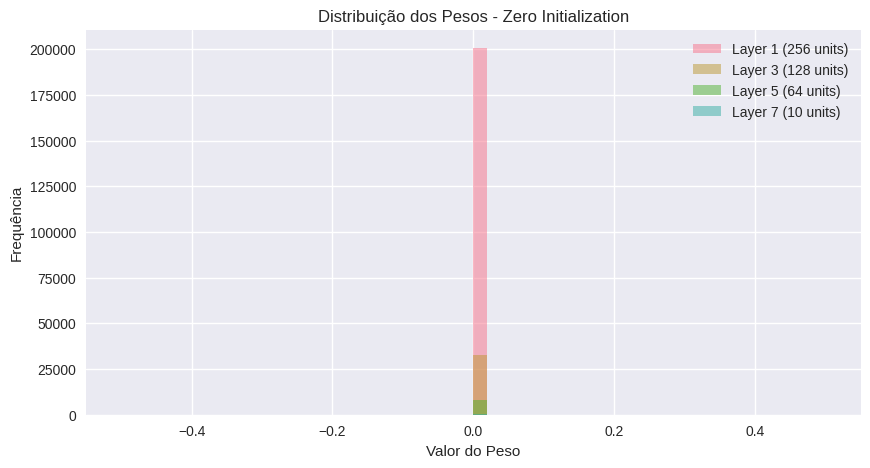

In [8]:
# Inicialização zero
for layer in model:
    if isinstance(layer, nn.Linear):
        init.zeros_(layer.weight)
        init.zeros_(layer.bias)

plot_weight_distribution(model, title="Zero Initialization")

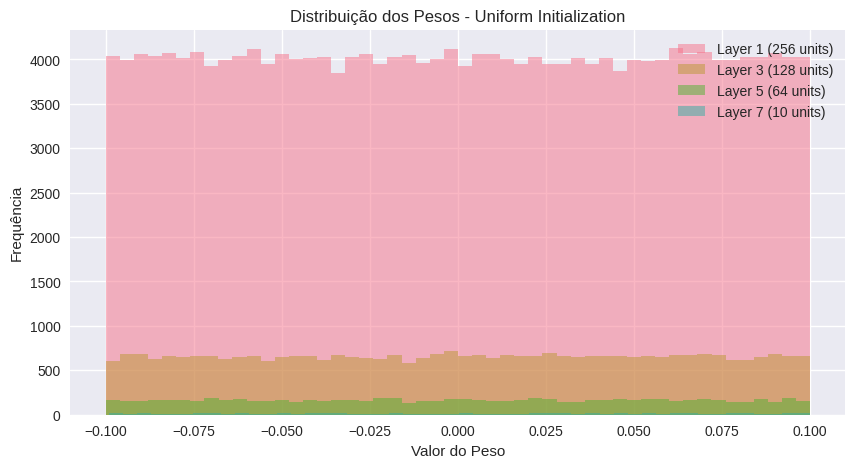

In [9]:
# Inicialização uniforme
for layer in model:
    if isinstance(layer, nn.Linear):
        init.uniform_(layer.weight, a=-0.1, b=0.1)
        init.zeros_(layer.bias)

plot_weight_distribution(model, title="Uniform Initialization")

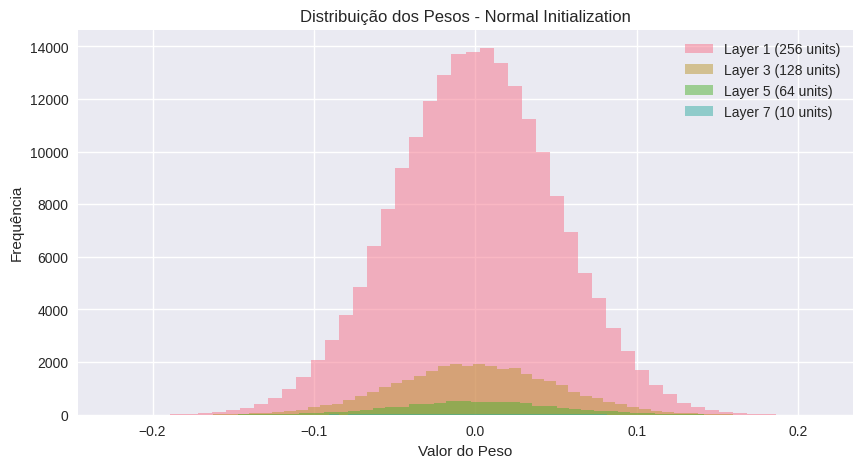

In [10]:
# Inicialização normal
for layer in model:
    if isinstance(layer, nn.Linear):
        init.normal_(layer.weight, mean=0.0, std=0.05)
        init.zeros_(layer.bias)

plot_weight_distribution(model, title="Normal Initialization")

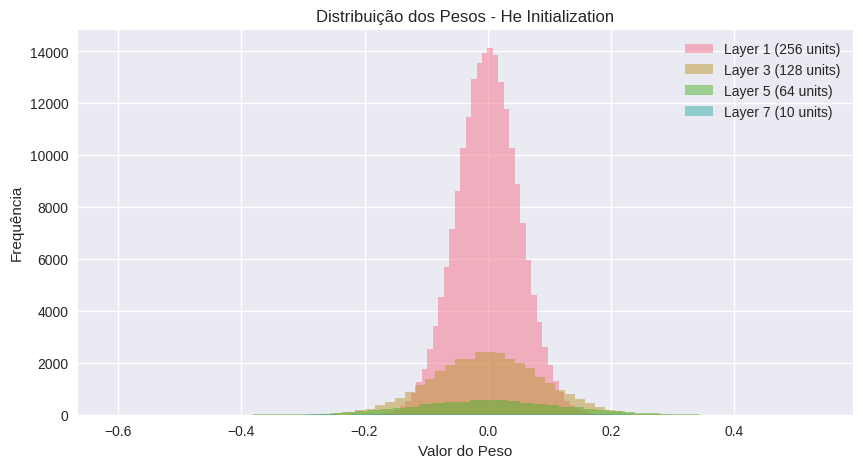

In [11]:
# Inicialização He
for layer in model:
    if isinstance(layer, nn.Linear):
        init.kaiming_normal_(layer.weight, nonlinearity="relu")
        init.zeros_(layer.bias)

plot_weight_distribution(model, title="He Initialization")

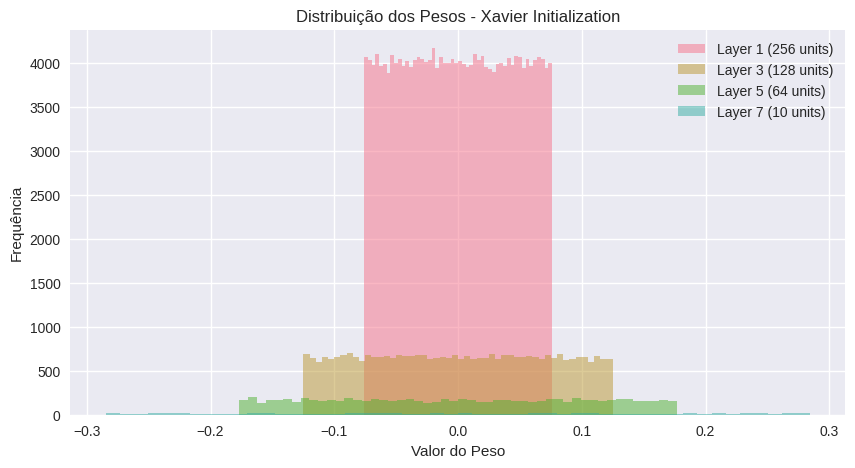

In [12]:
# Inicialização Xavier
for layer in model:
    if isinstance(layer, nn.Linear):
        init.xavier_uniform_(layer.weight)
        init.zeros_(layer.bias)

plot_weight_distribution(model, title="Xavier Initialization")

## Decaimento da Taxa de Aprendizado

A **taxa de aprendizado** ($\eta$) controla o tamanho dos passos do otimizador.  
Se $\eta$ for muito alta, o treinamento pode divergir; se for muito baixa, pode ser lento.  
Uma estratégia comum é aplicar **decaimento da taxa de aprendizado**, ajustando gradualmente $\eta$ ao longo do treinamento:

- **Step Decay**: reduz $\eta$ em etapas fixas, após um número pré-definido de épocas  

$$
\eta_t = \eta_0 \cdot \gamma^{\lfloor t / s \rfloor}
$$

- **Exponential Decay**: reduz $\eta$ de forma suave e contínua  

$$
\eta_t = \eta_0 \cdot \gamma^t
$$

- **Reduce on Plateau**: monitora uma métrica (ex.: loss de validação) e reduz $\eta$ quando não há melhora por certo número de épocas  

$$
\eta_{t+1} = \eta_t \cdot \gamma \quad \text{se não houver melhora por $p$ épocas}
$$

Epoch 1/15, Loss = 1.5277, LR = 0.50000
Epoch 2/15, Loss = 0.9069, LR = 0.50000
Epoch 3/15, Loss = 0.8511, LR = 0.50000
Epoch 4/15, Loss = 0.6709, LR = 0.50000
Epoch 5/15, Loss = 0.5062, LR = 0.50000
Epoch 6/15, Loss = 0.3099, LR = 0.05000
Epoch 7/15, Loss = 0.2706, LR = 0.05000
Epoch 8/15, Loss = 0.2555, LR = 0.05000
Epoch 9/15, Loss = 0.2463, LR = 0.05000
Epoch 10/15, Loss = 0.2343, LR = 0.05000
Epoch 11/15, Loss = 0.2216, LR = 0.00500
Epoch 12/15, Loss = 0.2204, LR = 0.00500
Epoch 13/15, Loss = 0.2189, LR = 0.00500
Epoch 14/15, Loss = 0.2185, LR = 0.00500
Epoch 15/15, Loss = 0.2179, LR = 0.00500


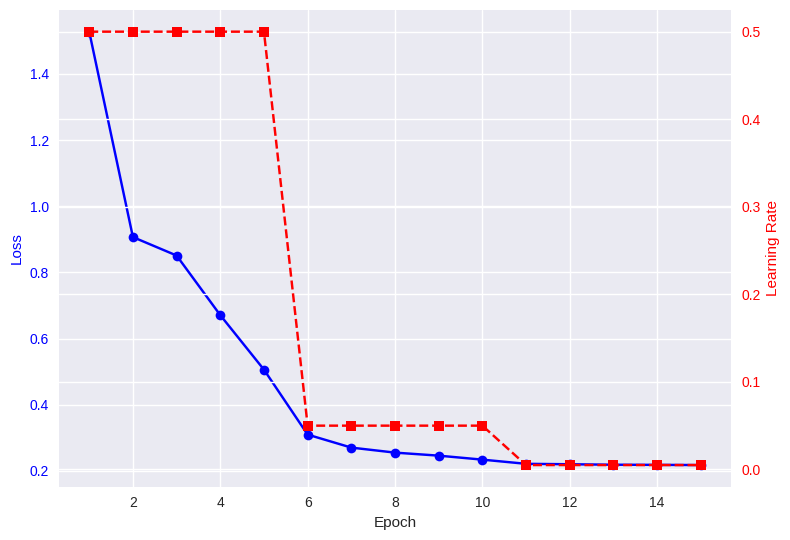

In [13]:
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau

# Modelo simples
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
).to(device)

# Otimizador e scheduler
optimizer = optim.SGD(model.parameters(), lr=0.5)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = ExponentialLR(optimizer, gamma=0.9)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.5)

criterion = nn.CrossEntropyLoss()

# Treinamento simples em MNIST
n_epochs = 15
train_losses = []
lrs = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss = {epoch_loss:.4f}, LR = {lrs[-1]:.5f}")

# Plot Loss e LR
fig, ax1 = plt.subplots()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="blue")
ax1.plot(range(1, n_epochs+1), train_losses, marker="o", color="blue", label="Train Loss")
ax1.tick_params(axis="y", labelcolor="blue")
ax2 = ax1.twinx()
ax2.set_ylabel("Learning Rate", color="red")
ax2.plot(range(1, n_epochs+1), lrs, marker="s", linestyle="--", color="red", label="LR")
ax2.tick_params(axis="y", labelcolor="red")
fig.tight_layout()
plt.show()

## Otimizadores

Os algoritmos de otimização são essenciais para treinar redes neurais. Eles buscam **minimizar a função de custo** $L(\theta)$ ajustando os parâmetros $\theta$ do modelo de forma iterativa.

### Gradiente Descendente Básico
Fornece um passo uniforme em todas as direções, sem considerar a escala ou correlação entre dimensões, o que pode gerar trajetórias lentas em funções mal condicionadas. O algoritmo atualiza os parâmetros na direção oposta ao gradiente:

$$\theta_{t+1} = \theta_t - \eta \nabla L(\theta_t)$$

- $\theta_t$: parâmetros atuais do modelo  
- $\eta$: taxa de aprendizado (tamanho do passo)  
- $\nabla L(\theta_t)$: gradiente da função de custo em relação aos parâmetros  

### Momentum
Reduz oscilações em direções de alta curvatura e acelera a convergência em vales alongados, aproximando-se de um método de aceleração de gradiente. Ele adiciona uma memória das atualizações anteriores:

$$v_{t+1} = \beta v_t + \nabla L(\theta_t)$$
$$\theta_{t+1} = \theta_t - \eta v_{t+1}$$

- $v_t$: vetor de "velocidade" acumulada  
- $\beta$: coeficiente de momentum (0.9 é comum)  
- $\eta$: taxa de aprendizado  

### AdaGrad
Normaliza o passo por dimensão, aumentando estabilidade em problemas esparsos, mas a acumulação crescente de $G_t$ tende a reduzir excessivamente a taxa de aprendizado ao longo do tempo. Sua atualização é dada por:

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \nabla L(\theta_t)$$

- $G_t$: soma acumulada dos quadrados dos gradientes  
- $\epsilon$: pequeno valor para estabilidade numérica  
- $\eta$: taxa de aprendizado inicial  

### RMSprop
Evita a saturação do AdaGrad ao introduzir esquecimento exponencial, permitindo adaptação contínua da taxa de aprendizado em problemas não estacionários. A regra de atualização é:

$$v_t = \beta v_{t-1} + (1-\beta)(\nabla L(\theta_t))^2$$
$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{v_t + \epsilon}} \nabla L(\theta_t)$$

- $v_t$: média móvel dos gradientes ao quadrado  
- $\beta$: fator de decaimento (tipicamente 0.9)  
- $\epsilon$: termo de estabilidade  
- $\eta$: taxa de aprendizado  

### Adam
Fornece estimativas corrigidas de primeira e segunda ordem, resultando em passos adaptativos que combinam aceleração e escalonamento por dimensão, o que o torna robusto em larga escala e em arquiteturas profundas. O procedimento é:

$$m_t = \beta_1 m_{t-1} + (1-\beta_1)\nabla L(\theta_t)$$
$$v_t = \beta_2 v_{t-1} + (1-\beta_2)(\nabla L(\theta_t))^2$$

Correções de viés (necessárias pois $m_t$ e $v_t$ tendem a começar enviesados para baixo no início):

$$\hat{m}_t = \frac{m_t}{1-\beta_1^t} \quad , \quad \hat{v}_t = \frac{v_t}{1-\beta_2^t}$$

Atualização final dos parâmetros:

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon}\,\hat{m}_t$$

- $m_t$: estimativa de primeira ordem (média móvel dos gradientes)  
- $v_t$: estimativa de segunda ordem (média móvel dos gradientes ao quadrado)  
- $\hat{m}_t, \hat{v}_t$: versões corrigidas de viés  
- $\beta_1$: fator de decaimento para $m_t$ (ex: 0.9)  
- $\beta_2$: fator de decaimento para $v_t$ (ex: 0.999)  
- $\epsilon$: termo de estabilidade numérica  
- $\eta$: taxa de aprendizado

### Função de Himmelblau

Para analisar e comparar diferentes otimizadores, utilizamos a **função de Himmelblau**, uma função clássica em otimização não convexa. Ela é definida como:

$$
f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2
$$

- Possui **quatro mínimos locais**, sendo todos também mínimos globais, além de pontos de sela.  
- É frequentemente usada como benchmark porque apresenta um relevo complexo, que desafia os algoritmos de otimização.  

In [14]:
import plotly.graph_objects as go

def himmelblau_np(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

# Grid
X = np.linspace(-6, 6, 200)
Y = np.linspace(-6, 6, 200)
X, Y = np.meshgrid(X, Y)
Z = himmelblau_np(X, Y)

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale="viridis")])

fig.update_layout(
    title="Himmelblau's Function",
    scene=dict(
        xaxis_title="x1",
        yaxis_title="x2",
        zaxis_title="f(x1, x2)"
    ),
    width=800,
    height=600
)

fig.show()

### Otimização em Funções Não Convexas

Considere uma função objetivo $f: \mathbb{R}^2 \to \mathbb{R}$ como a função de Himmelblau:

$$
f(x_1, x_2) = (x_1^2 + x_2 - 11)^2 + (x_1 + x_2^2 - 7)^2
$$

Esse tipo de função apresenta múltiplos mínimos locais e pontos de sela, o que a torna um bom cenário para comparar otimizadores.

O problema geral de otimização pode ser formulado como:

$$
\min_{x \in \mathbb{R}^n} f(x)
$$

onde $x = (x_1, x_2, \dots, x_n)$ são os parâmetros que queremos ajustar.

Durante o processo iterativo, mantemos uma sequência de pontos $\{x_t\}$, atualizados de acordo com uma regra específica definida por cada otimizador. Em geral:

$$
x_{t+1} = x_t - \Delta_t
$$

- $x_t$: vetor de parâmetros na iteração $t$  
- $\Delta_t$: passo de atualização definido pelo algoritmo  

In [15]:
def himmelblau(x):
    x1, x2 = x[0], x[1]
    return (x1**2 + x2 - 11)**2 + (x1 + x2**2 - 7)**2

def plot_progress(track, losses, func, title=""):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))

    # Contours of the function
    X = np.linspace(-6, 6, 400)
    Y = np.linspace(-6, 6, 400)
    X, Y = np.meshgrid(X, Y)
    Z = (X**2 + Y - 11)**2 + (X + Y**2 - 7)**2
    ax1.contour(X, Y, Z, levels=np.logspace(0, 5, 35), cmap='viridis')

    track = torch.stack(track).t()
    ax1.plot(track[0,:], track[1,:], marker='o', color="red")
    ax1.scatter(track[0,0], track[1,0], color='yellow', marker='*', s=200, label="start")
    ax1.set_title(f'progress of x ({title})')
    ax1.set_xlim(-6, 6)
    ax1.set_ylim(-6, 6)
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    ax1.legend()

    # Loss curve
    ax2.set_title(f'progress of f(x) ({title})')
    ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    ax2.plot(range(len(losses)), losses, marker='o')
    ax2.set_ylabel('objective')
    ax2.set_xlabel('iteration')
    ax2.set_yscale("log")

    plt.show()

def run_optimizer(opt_class, opt_params, x_init, steps=50, lr=0.01):
    x = x_init.clone().detach().requires_grad_(True)
    optimizer = opt_class([x], lr=lr, **opt_params)
    track, losses = [], []
    for _ in range(steps):
        optimizer.zero_grad()
        loss = himmelblau(x)
        loss.backward()
        optimizer.step()
        track.append(x.detach().clone())
        losses.append(loss.item())
    return track, losses

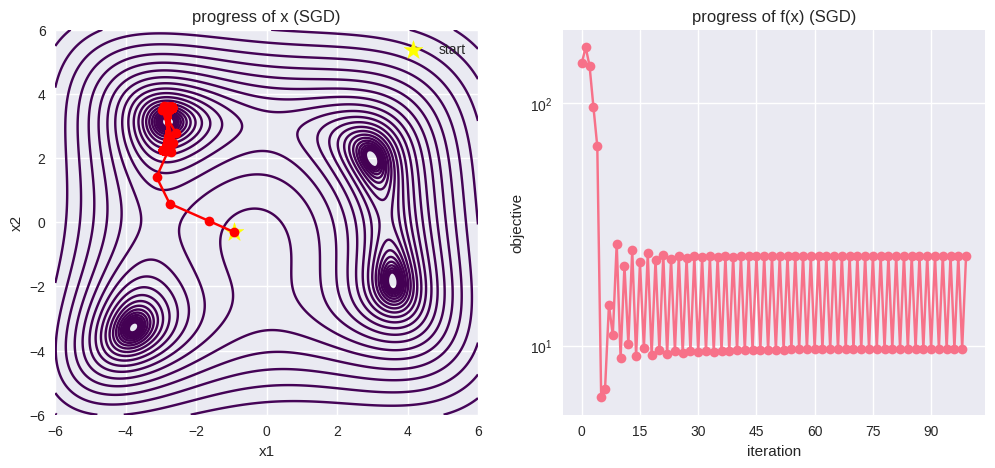

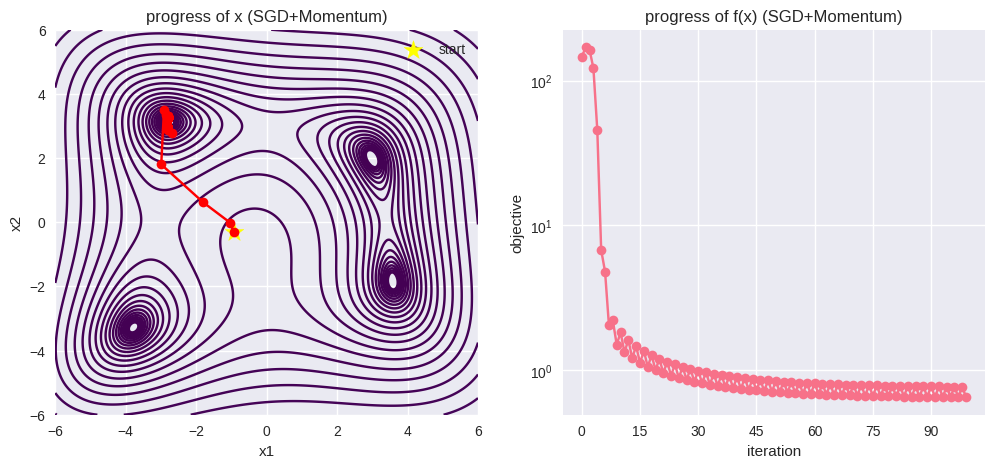

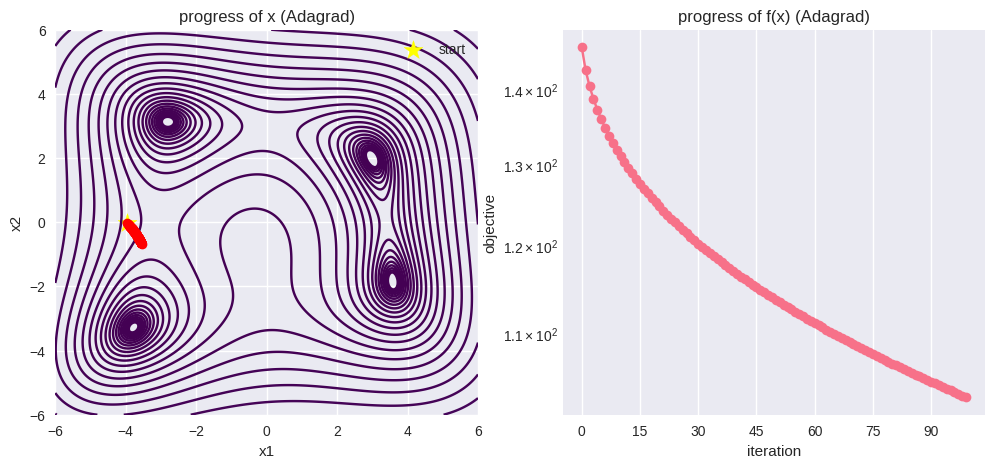

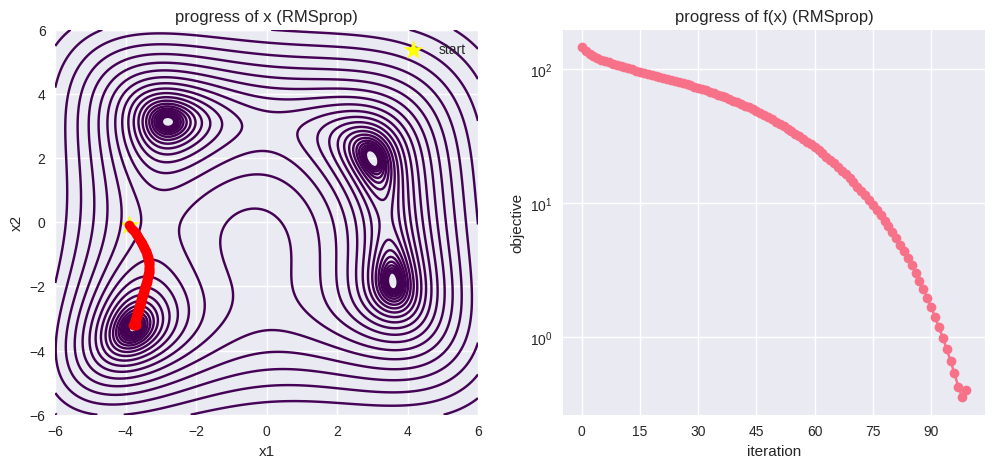

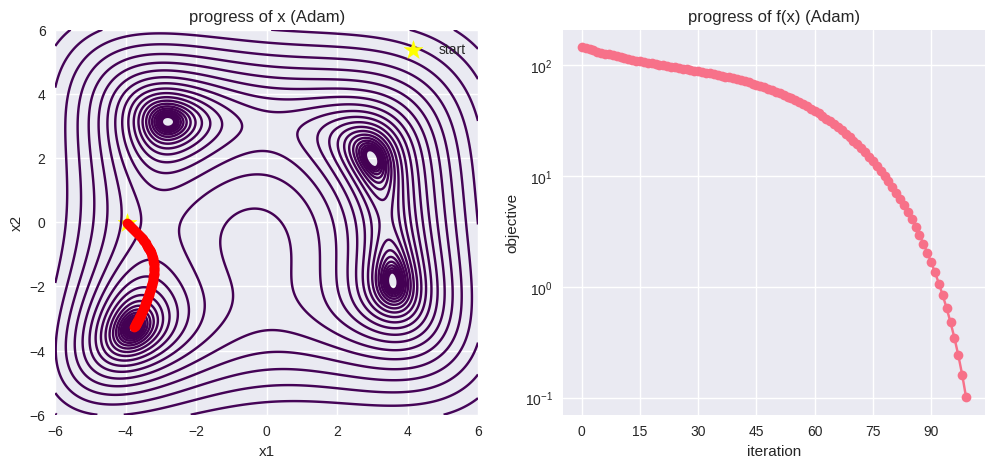

In [16]:
optimizers = {
    "SGD": (optim.SGD, {}),
    "SGD+Momentum": (optim.SGD, {"momentum": 0.2}),
    "Adagrad": (optim.Adagrad, {}),
    "RMSprop": (optim.RMSprop, {"alpha": 0.9}),
    "Adam": (optim.Adam, {})
}

x_start = torch.tensor([-4.0, 0.0])  # far from any minimum

for name, (opt_class, opt_params) in optimizers.items():
    track, losses = run_optimizer(opt_class, opt_params, x_start, steps=100, lr=0.03)
    plot_progress(track, losses, himmelblau, title=name)

### Modelo Completo

Agora reunimos em um único modelo os principais elementos discutidos e comparamos diferentes otimizadores.

In [17]:
class SimpleNet(nn.Module):
    def __init__(self, init_type="he", dropout=0.0):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(784, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            nn.Linear(64, 10)
        )
        self._initialize_weights(init_type)

    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)

    def _initialize_weights(self, init_type):
        for m in self.layers:
            if isinstance(m, nn.Linear):
                if init_type == "he":
                    init.kaiming_normal_(m.weight, nonlinearity="relu")
                    init.zeros_(m.bias)
                elif init_type == "xavier":
                    init.xavier_uniform_(m.weight)
                    init.zeros_(m.bias)
                elif init_type == "zeros":
                    init.zeros_(m.weight)
                    init.zeros_(m.bias)
                elif init_type == "uniform":
                    init.uniform_(m.weight, a=-0.1, b=0.1)
                    init.zeros_(m.bias)

In [18]:
def train_model(model, train_loader, val_loader, optimizer, epochs=10, device="cpu"):
    criterion = nn.CrossEntropyLoss()
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    model = model.to(device)

    for epoch in range(epochs):
        # ---- Treino ----
        model.train()
        total_loss, correct, total = 0, 0, 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        history["train_loss"].append(total_loss / len(train_loader))
        history["train_acc"].append(100 * correct / total)

        # ---- Validação ----
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)

                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        history["val_loss"].append(val_loss / len(val_loader))
        history["val_acc"].append(100 * correct / total)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {history['train_loss'][-1]:.4f}, "
              f"Train Acc: {history['train_acc'][-1]:.2f}% | "
              f"Val Loss: {history['val_loss'][-1]:.4f}, "
              f"Val Acc: {history['val_acc'][-1]:.2f}%")

    return history

In [19]:
optimizers_config = {
    'SGD': {'lr': 0.01},
    'SGD+Momentum': {'lr': 0.01, 'momentum': 0.9},
    'Adagrad': {'lr': 0.01},
    'RMSprop': {'lr': 0.01},
    'Adam': {'lr': 0.01}
}

results = {}

for name, config in optimizers_config.items():
    print(f"\nTreinando com {name}...")

    # novo modelo a cada otimizador
    model = SimpleNet(init_type="he", dropout=0.0).to(device)

    # instanciar otimizador
    optimizer_class = getattr(optim, name.split('+')[0])
    optimizer = optimizer_class(model.parameters(), **config)

    # treinar e guardar histórico
    history = train_model(model, train_loader, val_loader, optimizer, epochs=10, device=device)
    results[name] = history


Treinando com SGD...
Epoch 1/10 | Train Loss: 1.8547, Train Acc: 37.63% | Val Loss: 1.3071, Val Acc: 60.80%
Epoch 2/10 | Train Loss: 1.1583, Train Acc: 68.50% | Val Loss: 0.9707, Val Acc: 74.80%
Epoch 3/10 | Train Loss: 0.9077, Train Acc: 77.33% | Val Loss: 0.8135, Val Acc: 80.40%
Epoch 4/10 | Train Loss: 0.7640, Train Acc: 83.47% | Val Loss: 0.7026, Val Acc: 83.50%
Epoch 5/10 | Train Loss: 0.6624, Train Acc: 85.53% | Val Loss: 0.6271, Val Acc: 85.60%
Epoch 6/10 | Train Loss: 0.5873, Train Acc: 87.13% | Val Loss: 0.5761, Val Acc: 86.90%
Epoch 7/10 | Train Loss: 0.5308, Train Acc: 87.90% | Val Loss: 0.5320, Val Acc: 87.90%
Epoch 8/10 | Train Loss: 0.4815, Train Acc: 89.83% | Val Loss: 0.4992, Val Acc: 88.60%
Epoch 9/10 | Train Loss: 0.4473, Train Acc: 90.07% | Val Loss: 0.4748, Val Acc: 89.00%
Epoch 10/10 | Train Loss: 0.4192, Train Acc: 90.90% | Val Loss: 0.4494, Val Acc: 89.10%

Treinando com SGD+Momentum...
Epoch 1/10 | Train Loss: 1.1660, Train Acc: 66.43% | Val Loss: 0.5274, Val A

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12,5))

colors = sns.color_palette("husl", len(results))

# Loss
plt.subplot(1,2,1)
for i, (name, hist) in enumerate(results.items()):
    color = colors[i]
    plt.plot(hist["train_loss"], label=f"{name} Train", color=color)
    plt.plot(hist["val_loss"], linestyle="--", label=f"{name} Val", color=color)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
for i, (name, hist) in enumerate(results.items()):
    color = colors[i]
    plt.plot(hist["train_acc"], label=f"{name} Train", color=color)
    plt.plot(hist["val_acc"], linestyle="--", label=f"{name} Val", color=color)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

## Exercício

Neste exercício, você deve aplicar os conceitos vistos em aula:

1. Carregue o dataset **Fashion-MNIST** de `torchvision.datasets.FashionMNIST` e aplique **normalização** com `transforms.Normalize`, calculando previamente a média e o desvio padrão.  
2. Construa um modelo de rede neural utilizando:  
   - **Camadas lineares** intercaladas com **Batch Normalization** e **ReLU**
   - **Inicialização He** para os pesos
3. Treine o modelo usando o **otimizador Adam**.  
4. Utilize o scheduler **ReduceLROnPlateau**, monitorando a loss de validação, para ajustar dinamicamente a taxa de aprendizado.  
5. Registre e plote a evolução da loss de treino e validação ao longo das épocas, além da curva da taxa de aprendizado.

In [ ]:
# 1. Carregar e normalizar Fashion-MNIST

# Carregar dataset apenas como Tensor para calcular mean e std
dataset_tmp_fashion = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True,
    transform=transforms.ToTensor()
)

# Concatenar todos os dados em um tensor
loader_tmp_fashion = torch.utils.data.DataLoader(dataset_tmp_fashion, batch_size=len(dataset_tmp_fashion), shuffle=False)
data_tmp_fashion = next(iter(loader_tmp_fashion))[0]

# Calcular mean e std por canal
mean_fashion = data_tmp_fashion.mean().item()
std_fashion = data_tmp_fashion.std().item()
print(f"Fashion-MNIST Mean: {mean_fashion:.4f}, Std: {std_fashion:.4f}")

# Transformação com normalização
transform_fashion = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean_fashion,), (std_fashion,))
])

# Datasets e DataLoaders
train_data_fashion = torchvision.datasets.FashionMNIST("./data", train=True, download=True, transform=transform_fashion)
test_data_fashion  = torchvision.datasets.FashionMNIST("./data", train=False, download=True, transform=transform_fashion)

train_loader_fashion = DataLoader(train_data_fashion, batch_size=64, shuffle=True)
val_loader_fashion   = DataLoader(test_data_fashion, batch_size=64)

print(len(train_data_fashion), len(test_data_fashion))

# 2. Construir o modelo
class FashionNet(nn.Module):
    def __init__(self, init_type="he", dropout=0.0):
        super(FashionNet, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(784, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            nn.Linear(64, 10)
        )
        self._initialize_weights(init_type)

    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)

    def _initialize_weights(self, init_type):
        for m in self.layers:
            if isinstance(m, nn.Linear):
                if init_type == "he":
                    init.kaiming_normal_(m.weight, nonlinearity="relu")
                    init.zeros_(m.bias)
                elif init_type == "xavier":
                    init.xavier_uniform_(m.weight)
                    init.zeros_(m.bias)
                elif init_type == "zeros":
                    init.zeros_(m.weight)
                    init.zeros_(m.bias)
                elif init_type == "uniform":
                    init.uniform_(m.weight, a=-0.1, b=0.1)
                    init.zeros_(m.bias)

model_fashion = FashionNet(init_type="he", dropout=0.2).to(device) # Adicionado dropout

# 3. Treinar com Adam e ReduceLROnPlateau
optimizer_fashion = optim.Adam(model_fashion.parameters(), lr=0.001) # Ajustado LR inicial

# 4. Scheduler ReduceLROnPlateau
scheduler_fashion = ReduceLROnPlateau(optimizer_fashion, mode='min', factor=0.1, patience=3, verbose=True)

criterion_fashion = nn.CrossEntropyLoss()
n_epochs_fashion = 20 # Aumentado o número de épocas para melhor visualização do scheduler

history_fashion = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "lrs": []}

model_fashion = model_fashion.to(device)

for epoch in range(n_epochs_fashion):
    # ---- Treino ----
    model_fashion.train()
    total_loss, correct, total = 0, 0, 0
    for data, target in train_loader_fashion:
        data, target = data.to(device), target.to(device)

        optimizer_fashion.zero_grad()
        output = model_fashion(data)
        loss = criterion_fashion(output, target)
        loss.backward()
        optimizer_fashion.step()

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    history_fashion["train_loss"].append(total_loss / len(train_loader_fashion))
    history_fashion["train_acc"].append(100 * correct / total)

    # ---- Validação ----
    model_fashion.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data, target in val_loader_fashion:
            data, target = data.to(device), target.to(device)

            output = model_fashion(data)
            loss = criterion_fashion(output, target)
            val_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_loss /= len(val_loader_fashion)
    history_fashion["val_loss"].append(val_loss)
    history_fashion["val_acc"].append(100 * correct / total)
    history_fashion["lrs"].append(optimizer_fashion.param_groups[0]['lr'])


    print(f"Epoch {epoch+1}/{n_epochs_fashion} | "
          f"Train Loss: {history_fashion['train_loss'][-1]:.4f}, "
          f"Train Acc: {history_fashion['train_acc'][-1]:.2f}% | "
          f"Val Loss: {history_fashion['val_loss'][-1]:.4f}, "
          f"Val Acc: {history_fashion['val_acc'][-1]:.2f}% | "
          f"LR: {history_fashion['lrs'][-1]:.6f}")

    # Step do scheduler com a loss de validação
    scheduler_fashion.step(val_loss)


# 5. Plotar resultados
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_fashion["train_loss"], label="Train Loss")
plt.plot(history_fashion["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy e Learning Rate
ax1 = plt.subplot(1, 2, 2)
ax1.plot(history_fashion["train_acc"], label="Train Acc", color="blue")
ax1.plot(history_fashion["val_acc"], label="Val Acc", color="green")
ax1.set_title("Accuracy and Learning Rate over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy (%)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(history_fashion["lrs"], label="Learning Rate", color="red", linestyle="--")
ax2.set_ylabel("Learning Rate", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()